In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import numpy as np
import matplotlib
import re

import matplotlib.pyplot as plt
from dedalus.extras import plot_tools

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

import os
from os import listdir
# Parameters
Lx, Lz = 40,1
Nx, Nz = 1280, 32
Ra_M = 1.0e6
D_0 = 0
D_H = 1/3
M_0 = 0
M_H = -1
N_s2=4/3
f=0.05

Prandtl = 0.7
dealias = 3/2
stop_sim_time = 2000
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# %%
# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# %%
# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
D = dist.Field(name='D', bases=(xbasis,zbasis))
M = dist.Field(name='M', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
uy = dist.Field(name='uy', bases=(xbasis,zbasis))
Z = dist.Field(name='Z', bases=zbasis)
tau_p = dist.Field(name='tau_p')
tau_B1 = dist.Field(name='tau_B1', bases=xbasis)
tau_B2 = dist.Field(name='tau_B2', bases=xbasis)
tau_D1 = dist.Field(name='tau_D1', bases=xbasis)
tau_D2 = dist.Field(name='tau_D2', bases=xbasis)
tau_M1 = dist.Field(name='tau_M1', bases=xbasis)
tau_M2 = dist.Field(name='tau_M2', bases=xbasis)
tau_u1 = dist.VectorField(coords,name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords,name='tau_u2', bases=xbasis)
tau_u3 = dist.Field(name='tau_u3', bases=xbasis)
tau_u4 = dist.Field(name='tau_u4', bases=xbasis)

# Substitutions    
#Kuo_Bretherton Equilibrium
kappa = (Ra_M * Prandtl/((M_0-M_H)*Lz**3))**(-1/2)
nu = (Ra_M / (Prandtl*(M_0-M_H)*Lz**3))**(-1/2)
print('kappa',kappa)
print('nu',nu)
Td=Lz**2/(nu*kappa)**(1/2)
Tc=(Lz/(M_0-M_H))**(1/2)
Tr=1/f
R_0=Tr/Tc
print('R_0',R_0)


x,z = dist.local_grids(xbasis,zbasis)
Z['g']=z
Z.change_scales(3/2)

ex,ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

B_op = (np.absolute(D - M - N_s2*Z)+ M + D - N_s2*Z)/2

Max = lambda A,B: (abs(A-N_s2*Z-B)+A-N_s2*Z+B)/2
eva = lambda A: A.evaluate()

dz= lambda A: d3.Differentiate(A, coords['z'])
dx= lambda A: d3.Differentiate(A, coords['x'])

ux=u@ex
uz=u@ez
dxux=dx(ux)
dzux=dz(ux)
dxuz=dx(uz)
dzuz=dz(uz)

ux2=ux*ux
uy2=uy*uy
uz2=uz*uz

grad_u = d3.grad(u) + ez* lift(tau_u1) # First-order reduction
grad_ux = grad_u@ex # First-order reduction
grad_uz = grad_u@ez # First-order reduction
grad_uy = d3.grad(uy) + ez*lift(tau_u3)# First-order reduction 
grad_M = d3.grad(M) + ez*lift(tau_M1) # First-order reduction
grad_D = d3.grad(D) + ez*lift(tau_D1) # First-order reduction

kappa 0.0011952286093343937
nu 0.0008366600265340755
R_0 20.0


In [3]:
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

recorded = False
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['M']
        drybuoyancy = file['tasks']['D']
        buoyancy = np.maximum(moistbuoyancy, drybuoyancy - N_s2 * z)
        if recorded == False:
            max_level_old = np.max(buoyancy)
            min_level_old = np.min(buoyancy)
            recorded = True
        else:
            max_level_new = np.max(buoyancy)
            min_level_new = np.min(buoyancy)
            if max_level_new > max_level_old:
                max_level_old = max_level_new
            if min_level_new < min_level_old:
                min_level_old = min_level_new
min_lev, max_lev = min_level_old, max_level_old
levels = np.arange(min_lev-(max_lev-min_lev)/32, max_lev+(max_lev-min_lev)/32, (max_lev-min_lev)/32)
print(levels)

['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5']
[-1.03464708 -0.99939899 -0.9641509  -0.9289028  -0.89365471 -0.85840662
 -0.82315853 -0.78791044 -0.75266234 -0.71741425 -0.68216616 -0.64691807
 -0.61166998 -0.57642188 -0.54117379 -0.5059257  -0.47067761 -0.43542952
 -0.40018142 -0.36493333 -0.32968524 -0.29443715 -0.25918906 -0.22394096
 -0.18869287 -0.15344478 -0.11819669 -0.0829486  -0.0477005  -0.01245241
  0.02279568  0.05804377  0.09329186  0.12853996]


[[26.      26.03125 26.0625  ... 29.9375  29.96875 30.     ]
 [26.      26.03125 26.0625  ... 29.9375  29.96875 30.     ]
 [26.      26.03125 26.0625  ... 29.9375  29.96875 30.     ]
 ...
 [26.      26.03125 26.0625  ... 29.9375  29.96875 30.     ]
 [26.      26.03125 26.0625  ... 29.9375  29.96875 30.     ]
 [26.      26.03125 26.0625  ... 29.9375  29.96875 30.     ]] [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.03225806 0.03225806 0.03225806 ... 0.03225806 0.03225806 0.03225806]
 [0.06451613 0.06451613 0.06451613 ... 0.06451613 0.06451613 0.06451613]
 ...
 [0.93548387 0.93548387 0.93548387 ... 0.93548387 0.93548387 0.93548387]
 [0.96774194 0.96774194 0.96774194 ... 0.96774194 0.96774194 0.96774194]
 [1.         1.         1.         ... 1.         1.         1.        ]]


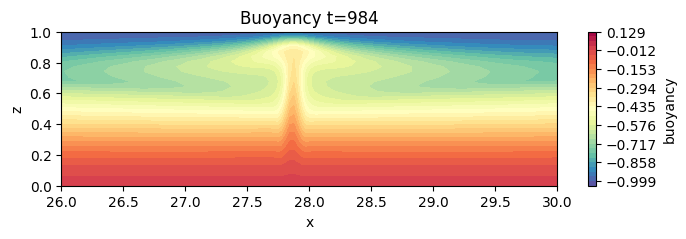

In [16]:
with h5py.File(file_paths[0], mode='r') as file:
    moistbuoyancy = file['tasks']['M']
    drybuoyancy = file['tasks']['D']
    buoyancy = np.maximum(moistbuoyancy, drybuoyancy - N_s2 * z)
    st = file['scales/sim_time']
    simtime = np.array(st)

    begin_x, end_x = 26*32, 30*32
    begin_y, end_y = 0, 32
    
    bu = np.transpose(buoyancy[984, begin_x: end_x+1, begin_y: end_y+1])
    n_rows, n_columns = bu.shape
    
    x_ax = np.linspace(begin_x/32, end_x/32, n_columns)
    y_ax = np.linspace(begin_y/32, end_y/32, n_rows)
    X_ax, Y_ax = np.meshgrid(x_ax, y_ax)
    print(X_ax, Y_ax)
    plt.figure(figsize=(8,2))
    plt.contourf(X_ax, Y_ax, bu, levels, cmap='Spectral_r')
    plt.colorbar(label='buoyancy')
    plt.xlabel('x')
    plt.ylabel('z')
    title = f"Buoyancy t=984"
    plt.title(title)
    plt.show()

In [10]:
def get_levels(taskname, name1, name2, folder_dir):

    file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
    #sort by the number in the file name
    file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
    print(file_paths)
    recorded = False
    for file in file_paths:
        with h5py.File(file, mode='r') as file:
            alldata = file['tasks'][f'{taskname}']
            if recorded == False:
                max_level_old = np.max(alldata)
                min_level_old = np.min(alldata)
                recorded = True
            else:
                max_level_new = np.max(alldata)
                min_level_new = np.min(alldata)
                if max_level_new > max_level_old:
                    max_level_old = max_level_new
                if min_level_new < min_level_old:
                    min_level_old = min_level_new
    min_lev, max_lev = min_level_old, max_level_old
    levels = np.arange(min_lev-(max_lev-min_lev)/32, max_lev+(max_lev-min_lev)/32, (max_lev-min_lev)/32)
    return levels

In [11]:
levels_LqW = get_levels("liquid water", "liquid_water", "liquid_water", "analysis_2")
levels_M = get_levels("M", "moist buoyancy", "mb", "snapshots")

['analysis_2/analysis_2_s1.h5', 'analysis_2/analysis_2_s2.h5']
['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5']


In [12]:
print(levels_LqW)
print(levels_M)

[-0.05133798 -0.01999914  0.0113397   0.04267854  0.07401738  0.10535622
  0.13669505  0.16803389  0.19937273  0.23071157  0.26205041  0.29338925
  0.32472808  0.35606692  0.38740576  0.4187446   0.45008344  0.48142228
  0.51276111  0.54409995  0.57543879  0.60677763  0.63811647  0.66945531
  0.70079414  0.73213298  0.76347182  0.79481066  0.8261495   0.85748834
  0.88882717  0.92016601  0.95150485  0.98284369]
[-1.03172111e+00 -1.00042893e+00 -9.69136744e-01 -9.37844564e-01
 -9.06552383e-01 -8.75260202e-01 -8.43968021e-01 -8.12675840e-01
 -7.81383659e-01 -7.50091478e-01 -7.18799297e-01 -6.87507116e-01
 -6.56214935e-01 -6.24922754e-01 -5.93630573e-01 -5.62338392e-01
 -5.31046211e-01 -4.99754030e-01 -4.68461850e-01 -4.37169669e-01
 -4.05877488e-01 -3.74585307e-01 -3.43293126e-01 -3.12000945e-01
 -2.80708764e-01 -2.49416583e-01 -2.18124402e-01 -1.86832221e-01
 -1.55540040e-01 -1.24247859e-01 -9.29556784e-02 -6.16634974e-02
 -3.03713165e-02  9.20864432e-04]


In [13]:

begin_x, end_x = 21*32, 36*32
begin_y, end_y = 0, 32
#figu_siz = ((end_x - begin_x) // 16, 2)

['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5']
[[21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 ...
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]] [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.03225806 0.03225806 0.03225806 ... 0.03225806 0.03225806 0.03225806]
 [0.06451613 0.06451613 0.06451613 ... 0.06451613 0.06451613 0.06451613]
 ...
 [0.93548387 0.93548387 0.93548387 ... 0.93548387 0.93548387 0.93548387]
 [0.96774194 0.96774194 0.96774194 ... 0.96774194 0.96774194 0.96774194]
 [1.         1.         1.         ... 1.         1.         1.        ]]


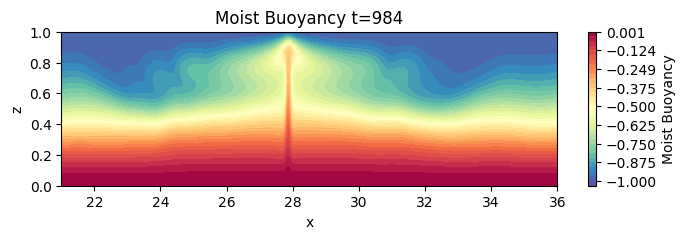

In [18]:
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

with h5py.File(file_paths[0], mode='r') as file:
    alldata_M = file['tasks']['M']
    st = file['scales/sim_time']
    simtime = np.array(st)

    
    part_data_M = np.transpose(alldata_M[984, begin_x: end_x+1, begin_y: end_y+1])
    n_rows, n_columns = part_data_M.shape
    
    x_ax = np.linspace(begin_x/32, end_x/32, n_columns)
    y_ax = np.linspace(begin_y/32, end_y/32, n_rows)
    X_ax, Y_ax = np.meshgrid(x_ax, y_ax)
    print(X_ax, Y_ax)
    plt.figure(figsize=(8,2))
    plt.contourf(X_ax, Y_ax, part_data_M, levels_M, cmap='Spectral_r')
    plt.colorbar(label='Moist Buoyancy')
    plt.xlabel('x')
    plt.ylabel('z')
    title = f"Moist Buoyancy t=984"
    plt.title(title)
    plt.savefig("poster_mb")
    plt.show()

['analysis_2/analysis_2_s1.h5', 'analysis_2/analysis_2_s2.h5']
[[21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 ...
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]] [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.03225806 0.03225806 0.03225806 ... 0.03225806 0.03225806 0.03225806]
 [0.06451613 0.06451613 0.06451613 ... 0.06451613 0.06451613 0.06451613]
 ...
 [0.93548387 0.93548387 0.93548387 ... 0.93548387 0.93548387 0.93548387]
 [0.96774194 0.96774194 0.96774194 ... 0.96774194 0.96774194 0.96774194]
 [1.         1.         1.         ... 1.         1.         1.        ]]


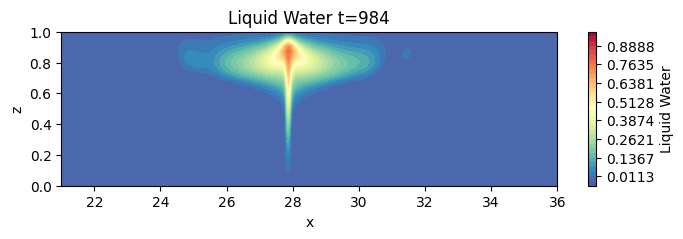

In [19]:
folder_dir = "analysis_2"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

with h5py.File(file_paths[0], mode='r') as file:
    alldata_LqW = file['tasks']['liquid water']
    st = file['scales/sim_time']
    simtime = np.array(st)

    
    part_data_LqW = np.transpose(alldata_LqW[984, begin_x: end_x+1, begin_y: end_y+1])
    n_rows, n_columns = part_data_LqW.shape
    
    x_ax = np.linspace(begin_x/32, end_x/32, n_columns)
    y_ax = np.linspace(begin_y/32, end_y/32, n_rows)
    X_ax, Y_ax = np.meshgrid(x_ax, y_ax)
    print(X_ax, Y_ax)
    plt.figure(figsize=(8,2))
    plt.contourf(X_ax, Y_ax, part_data_LqW, levels_LqW, cmap='Spectral_r')
    #plt.contourf(X_ax, Y_ax, part_data_LqW, levels_LqW, cmap='Blues_r')
    plt.colorbar(label='Liquid Water')
    plt.xlabel('x')
    plt.ylabel('z')
    title = f"Liquid Water t=984"
    plt.title(title)
    plt.savefig("poster_lqw")
    plt.show()

['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5']
[[21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 ...
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]] [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.03225806 0.03225806 0.03225806 ... 0.03225806 0.03225806 0.03225806]
 [0.06451613 0.06451613 0.06451613 ... 0.06451613 0.06451613 0.06451613]
 ...
 [0.93548387 0.93548387 0.93548387 ... 0.93548387 0.93548387 0.93548387]
 [0.96774194 0.96774194 0.96774194 ... 0.96774194 0.96774194 0.96774194]
 [1.         1.         1.         ... 1.         1.         1.        ]]


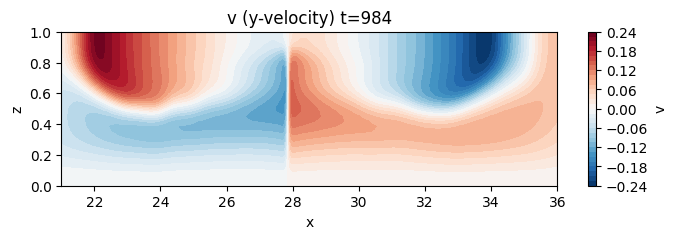

In [7]:
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

with h5py.File(file_paths[0], mode='r') as file:
    alldata_uy = file['tasks']['uy']
    st = file['scales/sim_time']
    simtime = np.array(st)
    
    part_data_uy = np.transpose(alldata_uy[984, begin_x: end_x+1, begin_y: end_y+1])
    n_rows, n_columns = part_data_uy.shape
    
    x_ax = np.linspace(begin_x//32, end_x//32, n_columns)
    y_ax = np.linspace(begin_y//32, end_y//32, n_rows)
    X_ax, Y_ax = np.meshgrid(x_ax, y_ax)
    print(X_ax, Y_ax)
    plt.figure(figsize=(8,2))
    plt.contourf(X_ax, Y_ax, part_data_uy, levels=32, cmap='RdBu_r')
    plt.colorbar(label='v')
    plt.xlabel('x')
    plt.ylabel('z')
    title = f"v (y-velocity) t=984"
    plt.title(title)
    plt.savefig("poster_v")
    plt.show()

['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5']
(32, 481)
[[21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 ...
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]
 [21.      21.03125 21.0625  ... 35.9375  35.96875 36.     ]] [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.03225806 0.03225806 0.03225806 ... 0.03225806 0.03225806 0.03225806]
 [0.06451613 0.06451613 0.06451613 ... 0.06451613 0.06451613 0.06451613]
 ...
 [0.93548387 0.93548387 0.93548387 ... 0.93548387 0.93548387 0.93548387]
 [0.96774194 0.96774194 0.96774194 ... 0.96774194 0.96774194 0.96774194]
 [1.         1.         1.         ... 1.         1.         1.        ]]


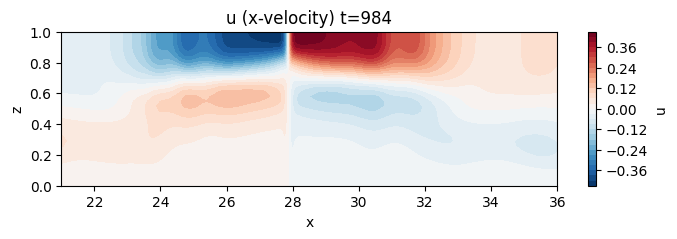

In [8]:
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#sort by the number in the file name
file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
print(file_paths)

with h5py.File(file_paths[0], mode='r') as file:
    alldata_uy = file['tasks']['u']
    st = file['scales/sim_time']
    simtime = np.array(st)
    part_data_ux = np.transpose(alldata_uy[984, 0, begin_x: end_x+1, begin_y: end_y+1])
    print(part_data_ux.shape)
    
    n_rows, n_columns = part_data_ux.shape
    
    x_ax = np.linspace(begin_x//32, end_x//32, n_columns)
    y_ax = np.linspace(begin_y//32, end_y//32, n_rows)
    X_ax, Y_ax = np.meshgrid(x_ax, y_ax)
    print(X_ax, Y_ax)
    plt.figure(figsize=(8,2))
    plt.contourf(X_ax, Y_ax, part_data_ux, levels=32, cmap='RdBu_r')
    plt.colorbar(label='u')
    plt.xlabel('x')
    plt.ylabel('z')
    title = f"u (x-velocity) t=984"
    plt.title(title)
    plt.savefig("poster_u")
    plt.show()